<a href="https://colab.research.google.com/github/Ali-Hossam/AI-Modeling-Notebooks/blob/main/Digits_Classifier_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# **Neural Network Classifier for MNIST Dataset**

This Jupyter Notebook implements a one-layer and two-layer neural network classifier from scratch using Python and PyTorch. The purpose of these classifiers is to classify images from the MNIST dataset, which consists of 28x28 pixel grayscale images of handwritten digits (0 to 9).

In [ ]:
# download MNIST dataset
path = untar_data(URLs.MNIST)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

## Data *preparation*

Get training and testing images directories in a list

In [ ]:
train_data_dir = (path/'training').ls().sorted()
test_data_dir = (path/'testing').ls().sorted()

print(train_data_dir)
print(test_data_dir)

[Path('/root/.fastai/data/mnist_png/training/0'), Path('/root/.fastai/data/mnist_png/training/1'), Path('/root/.fastai/data/mnist_png/training/2'), Path('/root/.fastai/data/mnist_png/training/3'), Path('/root/.fastai/data/mnist_png/training/4'), Path('/root/.fastai/data/mnist_png/training/5'), Path('/root/.fastai/data/mnist_png/training/6'), Path('/root/.fastai/data/mnist_png/training/7'), Path('/root/.fastai/data/mnist_png/training/8'), Path('/root/.fastai/data/mnist_png/training/9')]
[Path('/root/.fastai/data/mnist_png/testing/0'), Path('/root/.fastai/data/mnist_png/testing/1'), Path('/root/.fastai/data/mnist_png/testing/2'), Path('/root/.fastai/data/mnist_png/testing/3'), Path('/root/.fastai/data/mnist_png/testing/4'), Path('/root/.fastai/data/mnist_png/testing/5'), Path('/root/.fastai/data/mnist_png/testing/6'), Path('/root/.fastai/data/mnist_png/testing/7'), Path('/root/.fastai/data/mnist_png/testing/8'), Path('/root/.fastai/data/mnist_png/testing/9')]


In [ ]:
train_data_dir = [i.ls().sorted() for i in train_data_dir]
test_data_dir = [i.ls().sorted() for i in test_data_dir]

Plot samples from the dataset

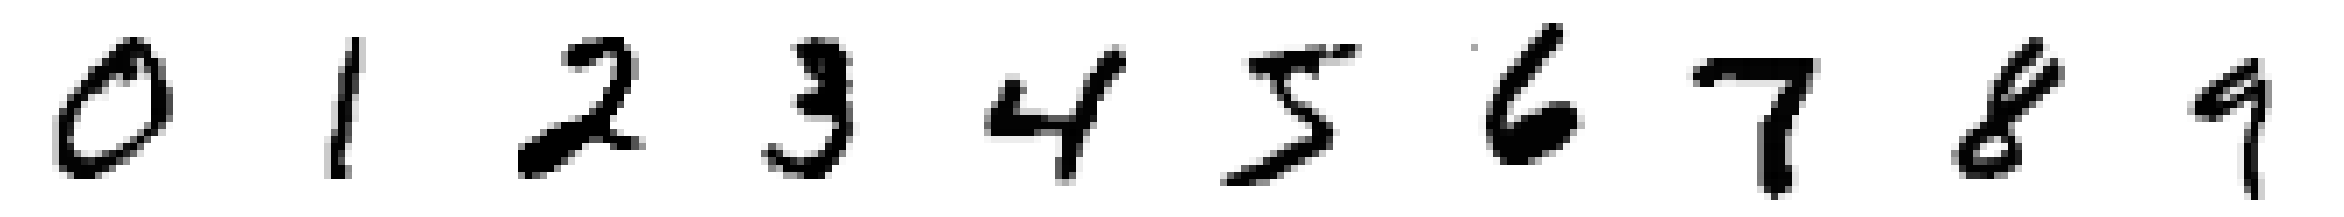

In [ ]:
# plot one sample from each class
samples = [Image.open(train_data_dir[i][0]) for i in range(10)]
show_images(samples)

Get training and testing data as tensors

In [ ]:
train_data = []
test_data = []

for i in range(10):
    train_data.append([tensor(Image.open(o)) for o in train_data_dir[i]])
    test_data.append([tensor(Image.open(o)) for o in test_data_dir[i]])


Check for dataset imbalance

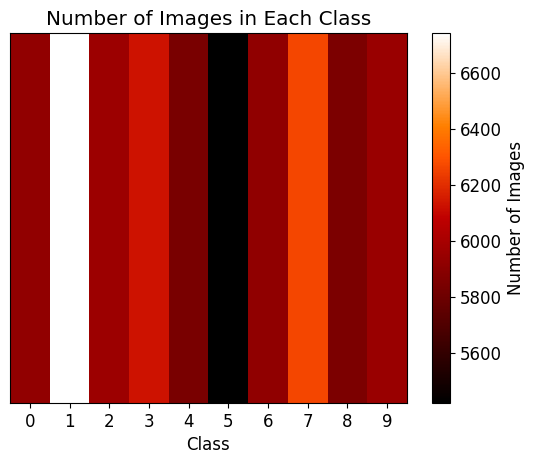

In [ ]:
# Create a 2D array representing the number of images for each class
data_matrix = np.array([[len(data) for data in train_data]])

# Plot the heatmap
plt.imshow(data_matrix, cmap='gist_heat', aspect='auto')

# Set axis labels and title
plt.xlabel('Class')
plt.title('Number of Images in Each Class')

# Show colorbar for reference
plt.colorbar(label='Number of Images')
plt.xticks(range(10), labels=range(10))
plt.yticks([])

# Show the plot
plt.show()

<!-- Check for Class Imbalance -->
After analyzing the dataset, it's evident that there is a class imbalance issue with a difference exceeding 1000 images between the class with the highest count and the one with the lowest count.


**Recommendations:**
we should Consider implementing strategies to address class imbalance, such as data augmentation, oversampling of minority classes, or using weighted loss functions during training.

## Baseline Model

We will consider our baseline model to be the mean of all images in each class.

In [ ]:
# stack images for each class as one tensor
stacked_train_data = [torch.stack(i).float()/255 for i in train_data]
stacked_val_data = [torch.stack(i).float()/255 for i in test_data]
stacked_train_data[0].shape

torch.Size([5923, 28, 28])

In [ ]:
baseline_model = [stacked_train_data[i].mean(0) for i in range(10)]

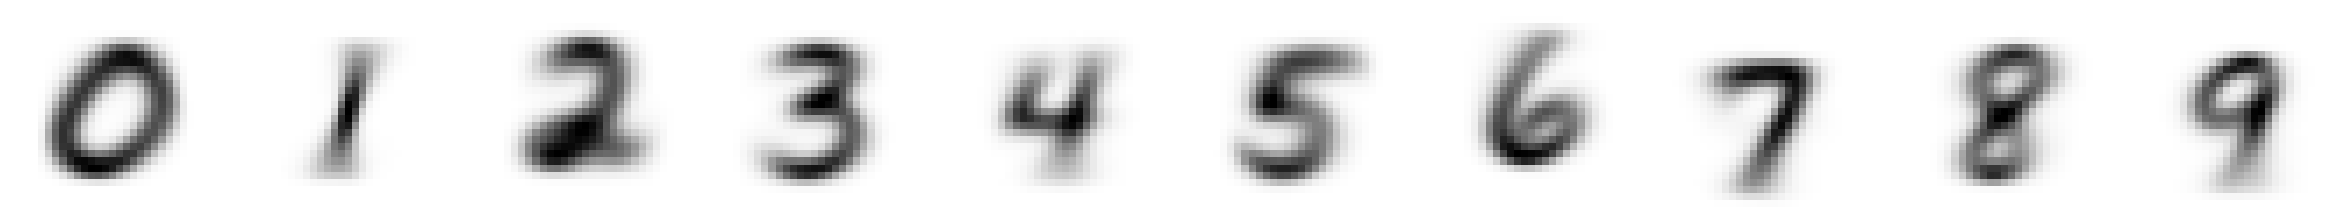

In [ ]:
# plot baseline images
show_images(baseline_model)
plt.show()

In [ ]:
def l2_distance(a, b):
    return torch.sqrt(torch.pow((a - b), 2)).mean((-1, -2)) # mean along width and height


In [ ]:
# distance between images in 0 class and 0 class baseline
l2_distance(stacked_train_data[0], baseline_model[0])

tensor([0.1108, 0.1388, 0.1648,  ..., 0.1840, 0.1632, 0.1759])

In [ ]:
total_accuracy = 0

for i in range(10):
    distances = []
    # add distance between this class and all baseline models
    for j in range(10):
        distances.append(l2_distance(stacked_train_data[i], baseline_model[j]))

    argmin_result = torch.stack(distances).argmin(dim=0)
    accuracy = (argmin_result == i).sum() / len(argmin_result)
    print(f"Accuracy for class {i} is {accuracy:.2f}")
    total_accuracy += accuracy

total_accuracy /= 10
print(f"Baseline model accuracy = {total_accuracy:.2f}")

Accuracy for class 0 is 0.81
Accuracy for class 1 is 1.00
Accuracy for class 2 is 0.43
Accuracy for class 3 is 0.58
Accuracy for class 4 is 0.66
Accuracy for class 5 is 0.30
Accuracy for class 6 is 0.75
Accuracy for class 7 is 0.78
Accuracy for class 8 is 0.40
Accuracy for class 9 is 0.72
Baseline model accuracy = 0.64


## Create a model from scratch

In [ ]:
# create training and validation data x, y
train_x = torch.cat(stacked_train_data).view(-1, 28*28)
train_y = [[i] * len(train_data[i]) for i in range(10)]
train_y = tensor(np.concatenate(train_y))

valid_x = torch.cat(stacked_val_data).view(-1, 28*28)
valid_y = [[i] * len(test_data[i]) for i in range(10)]
valid_y = tensor(np.concatenate(valid_y))

# create a dataset
train_dataset = list(zip(train_x, train_y))
valid_dataset = list(zip(valid_x, valid_y))

In [ ]:
# create dataloders
train_dl = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [ ]:
# get a sample of the dataloader
x1, y1 = first(train_dl)
x1.shape, y1.shape

(torch.Size([256, 784]), torch.Size([256]))

where x are the images and y are the lables

In [ ]:
batch_size = 256

In [ ]:
def init_params(size, std=1.0):
    """returns random weights tensor of some given size"""
    return (torch.randn(size) * std).requires_grad_()

In [ ]:
# model one : which is just a linear function
def linear(xb, params):
    """apply linear function to input x"""
    preds = xb@params[0] + params[1]
    return preds

In [ ]:
# model two: a linear function followed by a relu activation function then another linear function
def simple_net(xb, params):
    """two layers neural network model"""
    output1 = linear(xb, params[:2])
    output2 = torch.tanh(output1)
    output3 = linear(output2, params[2:])
    return output3

In [ ]:
class CustomLearner:
    def __init__(self, train_dl, valid_dl, model, lr, epochs, params):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.model = model
        self.lr = lr   # learning rate
        self.epochs = epochs
        self.params = params  # weights and biases (W1, B1, W2, B2, ...)

    def init_params(self, size, std=1.0):
        """Returns random weights tensor of some given size"""
        return (torch.randn(size) * std).requires_grad_()

    def CE_loss(self, predictions, targets):
        """applies cross entropy loss"""
        log_softmax_predictions = torch.log_softmax(predictions, dim=1)
        yi = torch.eye(predictions.shape[1])[targets]
        loss = -(log_softmax_predictions * yi).mean()
        return loss * 10

    def calc_accuracy(self, preds, targets):
        """calculates accuracy based on predictions max probability"""
        preds = preds.argmax(dim=1)
        return torch.sum(preds == targets).item() / len(targets)

    def get_params(self):
        """returns model parameters"""
        return self.params

    def predict(self, input):
        """predicts the label of an image"""
        prediction_prob = self.model(input, self.params)
        pred = prediction_prob.argmax()
        return pred

    def forward(self):
        string = "epoch    train_loss    valid_loss    train_accuracy    valid_accuracy"
        print(string)
        print("-" * len(string.expandtabs()))
        history = []
        for _ in range(self.epochs):
            total_train_accuracy = 0
            total_valid_accuracy = 0
            total_train_loss = 0
            total_valid_loss = 0

            # training loop
            for i, (xb, yb) in enumerate(self.train_dl):
                # Forward pass
                preds = self.model(xb, self.params)

                # calculate loss
                train_loss = self.CE_loss(preds, yb)

                # Backward pass
                train_loss.backward()

                # Update weights and biases using gradient descent
                with torch.no_grad():
                    for j in range(len(self.params)):
                        self.params[j].data -= self.params[j].grad * self.lr
                        self.params[j].grad.zero_()
                    # self.bias.data -= self.bias.grad * self.lr

                    # # Set gradients to zero before next gradient update
                    # self.weights.grad.zero_()
                    # self.bias.grad.zero_()

                batch_accuracy = self.calc_accuracy(preds, yb)
                total_train_accuracy += batch_accuracy
                total_train_loss += train_loss

            total_train_accuracy /= (i+1)
            total_train_loss /= (i+1)

            # validation loop
            with torch.no_grad():
                for i, (xb, yb) in enumerate(self.valid_dl):
                    # Forward pass
                    preds = self.model(xb, self.params)

                    # calculate loss
                    valid_loss = self.CE_loss(preds, yb)
                    total_valid_loss += valid_loss

                    # calculate accuracy
                    batch_accuracy = self.calc_accuracy(preds, yb)
                    total_valid_accuracy += batch_accuracy

            total_valid_accuracy /= (i+1)
            total_valid_loss /= (i+1)
            history.append([total_train_loss.item(), total_valid_loss.item(),
                            total_train_accuracy, total_valid_accuracy])

            print(f'  {_}', f'   {total_train_loss.item():.2f}', f'\t {total_valid_loss.item():.2f}',
                f'\t {total_train_accuracy:.2f}', f'\t   {total_valid_accuracy:.2f}', sep='\t')

        return np.array(history)


Train on the linear model

In [ ]:
weights = init_params((28*28, 10), 1)
bias = init_params(1)
learn = CustomLearner(train_dl, valid_dl, linear, 1, 30, (weights, bias))

In [ ]:
history1 = learn.forward()

epoch    train_loss    valid_loss    train_accuracy    valid_accuracy
---------------------------------------------------------------------
  0	   1.38		 0.71		 0.76		   0.85
  1	   0.66		 0.57		 0.86		   0.87
  2	   0.55		 0.53		 0.87		   0.88
  3	   0.49		 0.49		 0.88		   0.89
  4	   0.46		 0.46		 0.89		   0.89
  5	   0.43		 0.43		 0.89		   0.89
  6	   0.41		 0.43		 0.90		   0.89
  7	   0.39		 0.43		 0.90		   0.89
  8	   0.38		 0.40		 0.90		   0.90
  9	   0.37		 0.38		 0.90		   0.90
  10	   0.36		 0.38		 0.91		   0.90
  11	   0.35		 0.36		 0.91		   0.91
  12	   0.34		 0.36		 0.91		   0.91
  13	   0.34		 0.37		 0.91		   0.90
  14	   0.33		 0.36		 0.91		   0.91
  15	   0.33		 0.34		 0.91		   0.91
  16	   0.32		 0.36		 0.91		   0.91
  17	   0.32		 0.36		 0.91		   0.90
  18	   0.32		 0.37		 0.92		   0.91
  19	   0.31		 0.35		 0.92		   0.91
  20	   0.31		 0.34		 0.92		   0.91
  21	   0.31		 0.33		 0.92		   0.91
  22	   0.30		 0.34		 0.92		   0.91
  23	   0.30		 0.35		 0.92		   0.91
  24	 

Train on the simple net model

In [ ]:
weights1 = init_params((28*28, 50), 1)
weights2 = init_params((50, 10), 1)

bias1 = init_params(1)
bias2 = init_params(1)

learn = CustomLearner(train_dl, valid_dl, simple_net, 1, 30, (weights1, bias1, weights2, bias2))

In [ ]:
history2 = learn.forward()

epoch    train_loss    valid_loss    train_accuracy    valid_accuracy
---------------------------------------------------------------------
  0	   1.09		 0.56		 0.74		   0.83
  1	   0.49		 0.44		 0.85		   0.86
  2	   0.41		 0.40		 0.88		   0.88
  3	   0.37		 0.36		 0.89		   0.89
  4	   0.34		 0.35		 0.90		   0.89
  5	   0.31		 0.32		 0.91		   0.91
  6	   0.30		 0.33		 0.91		   0.91
  7	   0.28		 0.30		 0.92		   0.91
  8	   0.27		 0.29		 0.92		   0.91
  9	   0.25		 0.28		 0.92		   0.92
  10	   0.24		 0.28		 0.93		   0.92
  11	   0.24		 0.28		 0.93		   0.92
  12	   0.23		 0.27		 0.93		   0.92
  13	   0.22		 0.27		 0.93		   0.92
  14	   0.21		 0.26		 0.94		   0.92
  15	   0.21		 0.25		 0.94		   0.93
  16	   0.20		 0.27		 0.94		   0.92
  17	   0.20		 0.26		 0.94		   0.93
  18	   0.19		 0.24		 0.94		   0.93
  19	   0.19		 0.24		 0.94		   0.93
  20	   0.18		 0.24		 0.95		   0.93
  21	   0.18		 0.24		 0.95		   0.93
  22	   0.18		 0.23		 0.95		   0.93
  23	   0.17		 0.23		 0.95		   0.93
  24	 

## Model Evaluation

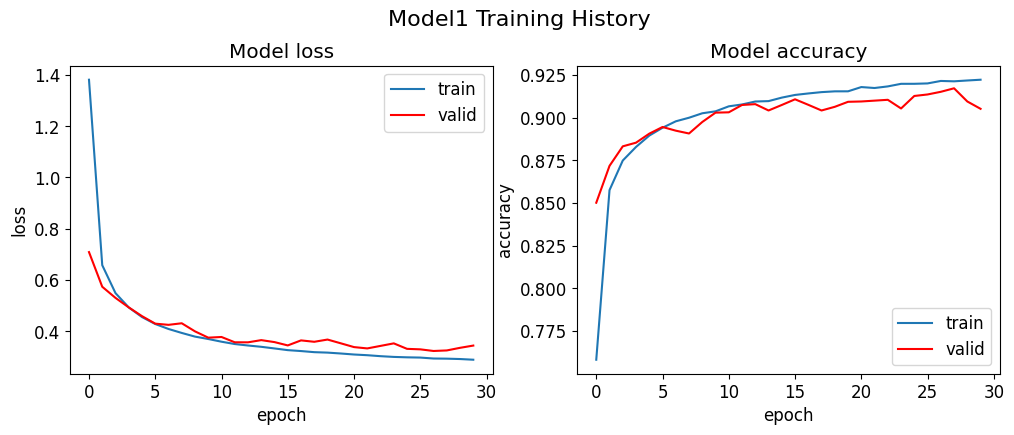

In [ ]:
h, w = history1.shape

# create a figure
plt.figure(figsize=(12, 4))

# losses plot
plt.subplot(1, 2, 1)
plt.plot(range(h), history1[:, 0], label="train")
plt.plot(range(h), history1[:, 1], label="valid", color='red')
plt.title("Model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(h), history1[:, 2], label="train")
plt.plot(range(h), history1[:, 3], label="valid", color='red')
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

# Add a common title to the entire figure
plt.suptitle("Model1 Training History", y=1.02, fontsize=16)

plt.show()

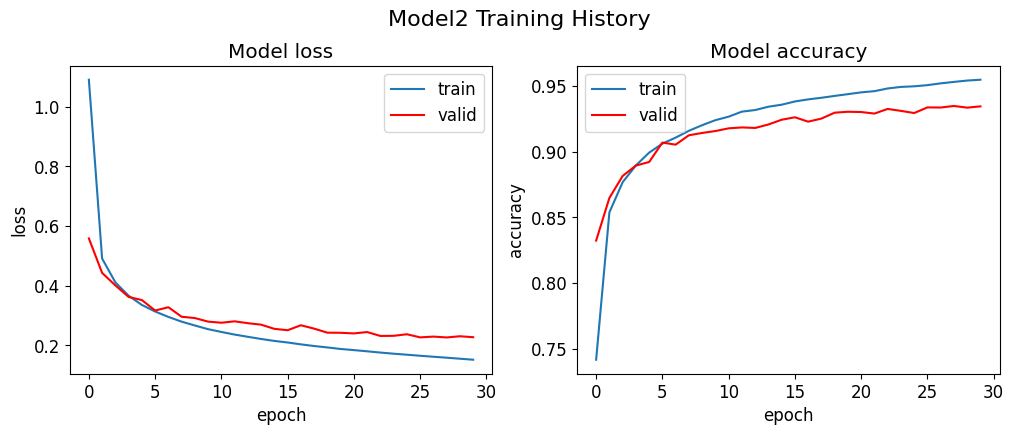

In [ ]:
h, w = history2.shape

# create a figure
plt.figure(figsize=(12, 4))

# losses plot
plt.subplot(1, 2, 1)
plt.plot(range(h), history2[:, 0], label="train")
plt.plot(range(h), history2[:, 1], label="valid", color='red')
plt.title("Model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(h), history2[:, 2], label="train")
plt.plot(range(h), history2[:, 3], label="valid", color='red')
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

# Add a common title to the entire figure
plt.suptitle("Model2 Training History", y=1.02, fontsize=16)

plt.show()

Test on a sample image

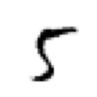

In [ ]:
# get sample image from validation dataset
sample_idx = np.random.randint(0, len(valid_dataset))
sample_img = valid_dataset[sample_idx][0]

show_image(sample_img.reshape((28, 28)));

In [ ]:
learn.predict(sample_img)

tensor(5)